In [1]:
# Useful starting lines
%matplotlib inline

import numpy as np
import scipy
import scipy.io
import scipy.sparse as sp
import matplotlib.pyplot as plt
import pandas as pd
%load_ext autoreload
%autoreload 2

## Load the Data
Note that `ratings` is a sparse matrix that in the shape of (num_items, num_users)

In [2]:
from helpers import load_data, preprocess_data

path_dataset = "data/data_train.csv"
ratings = load_data(path_dataset)

number of items: 1000, number of users: 10000


### Plot the number of ratings per movie and user

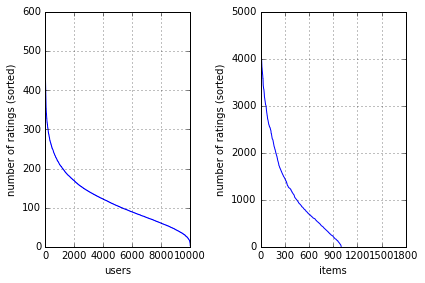

min # of items per user = 3, min # of users per item = 8.


In [3]:
from plots import plot_raw_data

num_items_per_user, num_users_per_item = plot_raw_data(ratings)

print("min # of items per user = {}, min # of users per item = {}.".format(
        min(num_items_per_user), min(num_users_per_item)))

### Split the data into a train and test set

In [4]:
def split_data(ratings, num_items_per_user, num_users_per_item,
               min_num_ratings, p_test=0.1):
    """split the ratings to training data and test data.
    Args:
        min_num_ratings: 
            all users and items we keep must have at least min_num_ratings per user and per item. 
    """
    # set seed
    np.random.seed(988)
    
    # select user and item based on the condition.
    valid_users = np.where(num_items_per_user >= min_num_ratings)[0]
    valid_items = np.where(num_users_per_item >= min_num_ratings)[0]
    valid_ratings = ratings[valid_items, :][: , valid_users]  
    
    # ***************************************************
    # INSERT YOUR CODE HERE
    # split the data and return train and test data. TODO
    # NOTE: we only consider users and movies that have more
    # than 10 ratings
    # ***************************************************
    
    # build rating matrix.
    rows, cols = ratings.get_shape()

    
    train = sp.lil_matrix((rows, cols))
    test = sp.lil_matrix((rows, cols))
    
    print(rows, cols)
    
    nz_row, nz_col = valid_ratings.nonzero()
    print(len(nz_col))
    print(len(nz_row))
    for i in range(0, len(nz_col)):
        rand = np.random.random()
        if rand > p_test:
            train[nz_row[i],nz_col[i]] = valid_ratings[nz_row[i],nz_col[i]]
        else:
            test[nz_row[i],nz_col[i]] = valid_ratings[nz_row[i],nz_col[i]]
               
    print("Total number of nonzero elements in original data:{v}".format(v=valid_ratings.nnz))
    print("Total number of nonzero elements in train data:{v}".format(v=train.nnz))
    print("Total number of nonzero elements in test data:{v}".format(v=test.nnz))
    return valid_ratings, train, test

In [5]:
from plots import plot_train_test_data

valid_ratings, train, test = split_data(
    ratings, num_items_per_user, num_users_per_item, min_num_ratings=0, p_test=0.1)

1000 10000
1176952
1176952
Total number of nonzero elements in original data:1176952
Total number of nonzero elements in train data:1058987
Total number of nonzero elements in test data:117965


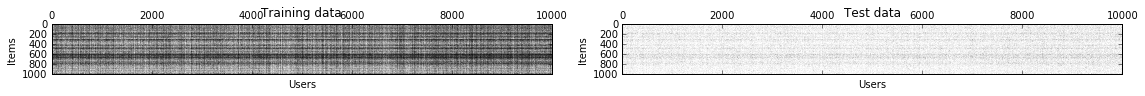

In [6]:
plot_train_test_data(train, test)

## Implementing Baselines 

### Use the global mean to do the prediction

In [49]:
from helpers import calculate_mse

def baseline_global_mean(train, test):
    """baseline method: use the global mean."""
    train_mean = train[train.nonzero()].mean()
    test_mean = test[test.nonzero()].mean()
    
    return train_mean, test_mean

mean = baseline_global_mean(train, test)
pred = np.ones(train.shape) * mean[0]
nz = valid_ratings.nonzero()
diff = valid_ratings[nz] - pred[nz]
rmse = 1/2 * np.sum(np.square(diff)) / len(nz[0])
rmse

0.6261441314983357

### Use the user means as the prediction

In [50]:
def baseline_user_mean(train, test):
    """baseline method: use the user means as the prediction."""
    mse = 0
    num_items, num_users = train.shape
    
    train_means = train.sum(axis = 0) / (train.getnnz(axis=0)+1e-12)
    test_means = test.sum(axis = 0) / (test.getnnz(axis=0)+1e-12)
    
    return train_means, test_means

mean = baseline_user_mean(train, test)
print(mean[0].shape)
means = mean[0].tolist()
print(train.shape)
pred = np.ones(train.shape)
for col in range(train.shape[1]):
    pred[:,col] *= means[0][col]
nz = valid_ratings.nonzero()
diff = valid_ratings[nz] - pred[nz]
rmse = 1/2 * np.sum(np.square(diff)) / len(nz[0])
rmse

(1, 10000)
(1000, 10000)


0.58919719707149609

### Use the item means as the prediction

In [51]:
def baseline_item_mean(train, test):
    """baseline method: use item means as the prediction."""
    mse = 0
    num_items, num_users = train.shape
    
    train_means = train.sum(axis = 1) / (train.getnnz(axis=1)+1e-12).reshape(num_items, 1)
    test_means = test.sum(axis = 1) / (test.getnnz(axis=1)+1e-12).reshape(num_items, 1)
    
    return train_means, test_means
    
mean = baseline_item_mean(train, test)
print(mean[0].shape)
means = mean[0].tolist()
print(len(means))
print(train.shape)
pred = np.ones(train.shape)
for col in range(train.shape[0]):
    pred[col,:] *= means[col]
nz = valid_ratings.nonzero()
diff = valid_ratings[nz] - pred[nz]
rmse = 1/2 * np.sum(np.square(diff)) / len(nz[0])
print(rmse)

exportSubmission("data/submission_item_mean.csv", pred)

(1000, 1)
1000
(1000, 10000)
0.529905886529


NameError: name 'exportSubmission' is not defined

### Learn the Matrix Factorization using SGD

#### Initialize matrix factorization

In [ ]:
def init_MF(train, num_features):
    """init the parameter for matrix factorization."""
    
    # ***************************************************
    # INSERT YOUR CODE HERE
    # TODO
    # you should return:
    #     user_features: shape = num_features, num_user
    #     item_features: shape = num_features, num_item
    # ***************************************************
    mean = baseline_global_mean(train, train)[0]
    num_items, num_users = train.shape
    user_features = np.ones((num_users, num_features))/np.sqrt(num_features/mean)
    item_features = np.ones((num_items, num_features))/np.sqrt(num_features/mean)
    
    return user_features, item_features

Compute the cost by the method of matrix factorization.


In [ ]:
def compute_error(data, user_features, item_features, nz):
    """compute the loss (MSE) of the prediction of nonzero elements."""
    # ***************************************************
    # INSERT YOUR CODE HERE
    # TODO
    # calculate rmse (we only consider nonzero entries.)
    # ***************************************************
    pred = item_features @ user_features.T
    diff = data[nz] - pred[nz]
    rmse = 1/2 * np.sum(np.square(diff)) / len(nz[0])
    
    return rmse

user_features, item_features = init_MF(train, 20)
compute_error(train, user_features, item_features, train.nonzero())
train.nonzero()

In [ ]:
import csv
import sys
def exportSubmission(path, pred):
    path_dataset = "data/sampleSubmission.csv"
    submission_ratings = load_data(path_dataset)
    submission_ratings.shape
    nz_row, nz_col = submission_ratings.nonzero()
    for i in range(0, len(nz_col)):
        submission_ratings[nz_row[i],nz_col[i]] = pred[nz_row[i],nz_col[i]]

    f = open(path, 'wt')
    try:
        writer = csv.writer(f)
        writer.writerow( ('Id', 'Prediction') )
        for i in range(0, len(nz_col)):
            ide = "r" + str(nz_col[i]+1) + "_c" + str(nz_row[i]+1)
            writer.writerow((ide, int(submission_ratings[nz_row[i],nz_col[i]] + 0.5)))
    finally:
        f.close()

In [ ]:
def factorize(V):
    """
    Perform SNMF/R factorization on the sparse MovieLens data matrix. 
    
    :param V: The MovieLens data matrix. 
    :type V: `numpy.matrix`
    """
    snmf = nimfa.Snmf(V, seed=None, rank=30, max_iter=30, version='r', eta=1.,
                      beta=1e-4, i_conv=10, w_min_change=0)
    print("Algorithm: %s\nInitialization: %s\nRank: %d" % (snmf, snmf.seed, snmf.rank))
    fit = snmf()
    print("snmf ran")
    return fit

In [174]:
import numpy as np
from sklearn.feature_extraction import DictVectorizer
from pyfm import pylibfm

# Read in data
def loadData(filename,path="data/"):
    data = []
    y = []
    with open(path+filename, "r") as f:
        lines = f.read().splitlines()[1:]
    for line in lines:
        (row_col, rating)=line.split(',')
        row, col = row_col.split('_')
        data.append({ "user_id": row, "movie_id": col})
        y.append(float(rating))

    return (data, np.array(y))

train_data, y_train = loadData("data_train.csv")
print(len(train_data))
X_train = v.fit_transform(train_data)
#X_test = v.transform(test_data)

# Build and train a Factorization Machine
fm = pylibfm.FM(num_factors=30, num_iter=20, verbose=True, task="regression", initial_learning_rate=0.005, learning_rate_schedule="optimal")

fm.fit(X_train,y_train)

# Evaluate
predictions = fm.predict(X_train)
from sklearn.metrics import mean_squared_error
print("FM MSE: %.4f" % mean_squared_error(y_train,predictions))

1176952
Creating validation dataset of 0.01 of training for adaptive regularization
-- Epoch 1
Training MSE: 0.51915
-- Epoch 2
Training MSE: 0.49774
-- Epoch 3
Training MSE: 0.49291
-- Epoch 4
Training MSE: 0.49001
-- Epoch 5
Training MSE: 0.48692
-- Epoch 6
Training MSE: 0.48299
-- Epoch 7
Training MSE: 0.47668
-- Epoch 8
Training MSE: 0.46966
-- Epoch 9
Training MSE: 0.46513
-- Epoch 10
Training MSE: 0.46155
-- Epoch 11
Training MSE: 0.45844
-- Epoch 12
Training MSE: 0.45525
-- Epoch 13
Training MSE: 0.45316
-- Epoch 14
Training MSE: 0.45194
-- Epoch 15
Training MSE: 0.45028
-- Epoch 16


KeyboardInterrupt: 

In [145]:
nz = valid_ratings.nonzero()
diff = valid_ratings[nz] - (preds[nz]
rmse = 1/2 * np.sum(np.square(diff)) / len(nz[0])
rmse

IndexError: too many indices for array

In [160]:
valid_ratings.shape

(1000, 10000)

In [168]:
preds = predictions

In [169]:
np.mean(np.abs(y_train - preds)*np.abs(y_train - preds))

0.73576972651948991

In [170]:
submit_data, y_submit = loadData("sampleSubmission.csv")
X_submit = v.fit_transform(train_data)

In [171]:
preds = fm.predict(X_submit)

In [172]:
import csv
import sys
def exportSubmission2(path, pred):
    path_dataset = "data/sampleSubmission.csv"
    submission_ratings = load_data(path_dataset)
    submission_ratings.shape
    nz_row, nz_col = submission_ratings.nonzero()
    for i in range(0, len(nz_col)):
        submission_ratings[nz_row[i],nz_col[i]] = pred[i]

    f = open(path, 'wt')
    try:
        writer = csv.writer(f)
        writer.writerow( ('Id', 'Prediction') )
        for i in range(0, len(nz_col)):
            ide = "r" + str(nz_col[i]+1) + "_c" + str(nz_row[i]+1)
            writer.writerow((ide, int(submission_ratings[nz_row[i],nz_col[i]] + 0.5)))
    finally:
        f.close()

In [173]:
exportSubmission2("data/sldakds", preds)

number of items: 1000, number of users: 10000


In [10]:
# Read in data
def loadDataFrame(path):
    d = []
    with open(path, "r") as f:
        lines = f.read().splitlines()[1:]
    for line in lines:
        (row_col, rating)=line.split(',')
        row_col = row_col.replace("r", "")
        row_col = row_col.replace("c", "")
        row, col = row_col.split('_')
        d.append([int(row), int(col), float(rating)])
        
    data = pd.DataFrame(d, columns = ["user", "item", "rating"])

    return data

In [11]:
path_dataset = "data/data_train.csv"
data = loadDataFrame(path_dataset)

In [9]:
data.head()

,user,item,rating
0,44,1,4.0
1,61,1,3.0
2,67,1,4.0
3,72,1,3.0
4,86,1,5.0


In [10]:
data.rating.mean()

3.8572805008190647

In [11]:
data.rating.std()

1.1190572091671531

In [12]:
data.rating.describe()

count    1.176952e+06
mean     3.857281e+00
std      1.119057e+00
min      1.000000e+00
25%      3.000000e+00
50%      4.000000e+00
75%      5.000000e+00
max      5.000000e+00
Name: rating, dtype: float64

In [13]:
data.groupby("rating").count().reset_index()

,rating,user,item
0,1.0,43508,43508
1,2.0,99180,99180
2,3.0,274327,274327
3,4.0,324700,324700
4,5.0,435237,435237


In [14]:
user_ratings = data.groupby("user").count()["item"].to_frame()
user_ratings.columns = ["nb ratings"]
user_ratings.describe()

,nb ratings
count,10000.000000
mean,117.695200
std,67.900609
min,3.000000
25%,68.000000
50%,104.000000
75%,153.000000
max,522.000000


In [15]:
mean_user = data.groupby("user")["rating"].mean().to_frame()
mean_user.head()

,rating
user,
1,4.043478
2,3.771812
3,3.523256
4,3.800000
5,3.985075


In [16]:
mean_user.std()

rating    0.274196
dtype: float64

In [17]:
std_user = data.groupby("user")["rating"].std().to_frame()
std_user.head()

,rating
user,
1,1.065076
2,1.180476
3,1.185468
4,1.239694
5,1.054778


In [18]:
std_user.describe()

,rating
count,10000.000000
mean,1.065531
std,0.149794
min,0.378535
25%,0.964366
50%,1.061773
75%,1.158456
max,1.786474


In [19]:
user_grouped = data.copy()
user_grouped["nb rating"] =  user_grouped.groupby(["user"])['rating'].transform('count')
user_grouped = user_grouped.sort_values(["user"])
user_grouped = user_grouped.groupby("user").agg({'rating' : [np.mean, np.std], 'nb rating' : np.mean})[["rating","nb rating"]].reset_index()
user_grouped.columns = ["user", "rating mean", "rating std", "nb rating"]
user_grouped.head()

,user,rating mean,rating std,nb rating
0,1,4.043478,1.065076,23
1,2,3.771812,1.180476,149
2,3,3.523256,1.185468,86
3,4,3.800000,1.239694,20
4,5,3.985075,1.054778,134


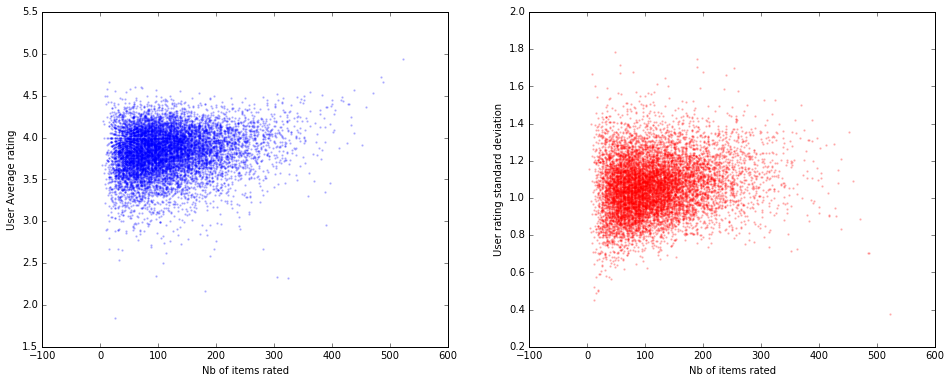

In [20]:
fig = plt.figure(figsize=(16, 6))
ax1 = fig.add_subplot(1, 2, 1)
ax1.scatter(user_grouped["nb rating"], user_grouped["rating mean"], color='b', s=2, marker='o', alpha=.2)
ax1.set_xlabel("Nb of items rated")
ax1.set_ylabel("User Average rating")
ax2 = fig.add_subplot(1, 2, 2)
ax2.scatter(user_grouped["nb rating"], user_grouped["rating std"], color='r', s=2, marker='o', alpha=.2)
ax2.set_xlabel("Nb of items rated")
ax2.set_ylabel("User rating standard deviation")

In [21]:
item_grouped = data.copy()
item_grouped["nb rating"] =  item_grouped.groupby(["item"])['rating'].transform('count')
item_grouped = item_grouped.sort_values(["item"])
item_grouped = item_grouped.groupby("item").agg({'rating' : [np.mean, np.std], 'nb rating' : np.mean})[["rating","nb rating"]].reset_index()
item_grouped.columns = ["item", "rating mean", "rating std", "nb rating"]
item_grouped.head()

,item,rating mean,rating std,nb rating
0,1,3.379412,1.061607,340
1,2,3.500942,1.030433,531
2,3,3.483586,1.073639,792
3,4,3.936473,1.180813,3164
4,5,3.559131,1.036532,1243


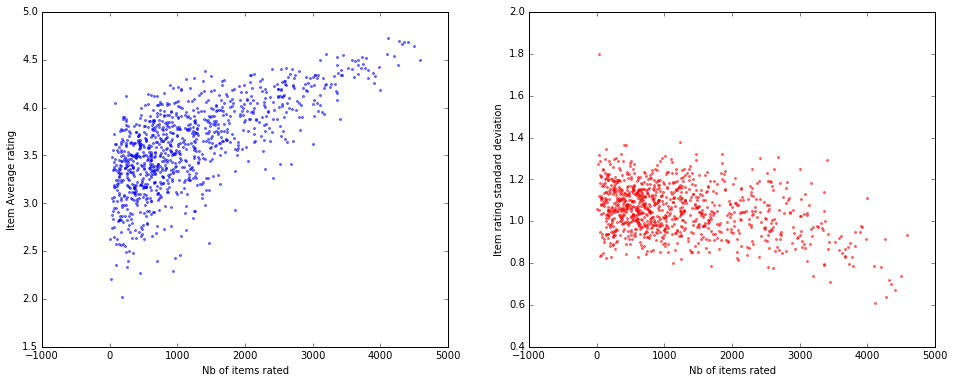

In [22]:
fig = plt.figure(figsize=(16, 6))
ax1 = fig.add_subplot(1, 2, 1)
ax1.scatter(item_grouped["nb rating"], item_grouped["rating mean"], color='b', s=4, marker='o', alpha=.5)
ax1.set_xlabel("Nb of items rated")
ax1.set_ylabel("Item Average rating")
ax2 = fig.add_subplot(1, 2, 2)
ax2.scatter(item_grouped["nb rating"], item_grouped["rating std"], color='r', s=4, marker='o', alpha=.5)
ax2.set_xlabel("Nb of items rated")
ax2.set_ylabel("Item rating standard deviation")

In [14]:
def predict(data, user_features, item_features):
    product = item_features @ user_features.T
    preds = data.copy()
    nz = preds.nonzero()
    preds[nz] = product[nz[0],nz[1]]
    return preds

In [15]:
def predict_user(data, mean_user):
    preds = data.copy()
    nz = preds.nonzero()
    preds[nz] = mean_user[nz[1]+1]
    return preds

In [16]:
def predict_item(data, mean_item):
    preds = data.copy()
    nz = preds.nonzero()
    preds[nz] = mean_item[nz[0]+1]
    return preds

In [39]:
def compute_rmse(data, preds):
    nz_item, nz_user = data.nonzero()
    diff = 0
    for i in range(0, len(nz_item)):
        diff += np.square(data[nz_item[i], nz_user[i]] - preds[nz_item[i], nz_user[i]])
    rmse = diff / len(nz_item)
    return rmse

In [28]:
mean_item = data.groupby("item").mean()["rating"]
mean_item.head()
preds_item = predict_item(valid_ratings, mean_item)
print(compute_rmse(valid_ratings, preds_item))

1.02942067458


In [29]:
mean_user = data.groupby("user").mean()["rating"]
mean_user.head()
preds_user = predict_user(valid_ratings, mean_user)
print(compute_rmse(valid_ratings, preds_user))

1.08502915952


In [30]:
# init matrix
mean = data["rating"].mean()
print(mean)
user_features, item_features = init_MF(valid_ratings, 20, mean)

# find the non-zero ratings indices 
nz_row, nz_col = train.nonzero()
nz_train = list(zip(nz_row, nz_col))

preds = predict(train, user_features, item_features)
rmse = compute_rmse(train, preds)
rmse

3.8572805008190647


1.1190982030259891

In [52]:
def init_MF(train, num_features, mean):
    """init the parameter for matrix factorization."""
    
    # ***************************************************
    # INSERT YOUR CODE HERE
    # TODO
    # you should return:
    #     user_features: shape = num_features, num_user
    #     item_features: shape = num_features, num_item
    # ***************************************************
    num_items, num_users = train.shape
    user_features = np.ones((num_users, num_features))/np.sqrt(num_features/mean)
    item_features = np.ones((num_items, num_features))/np.sqrt(num_features/mean)
    
    return user_features, item_features

In [65]:
from plots import visualization

def matrix_factorization_SGD(train, num_epochs=50, num_features=20):
    """matrix factorization by SGD."""
    # define parameters
    gamma = 0.0005
    lambda_user = 0.1
    lambda_item = 0.7
    errors = []
    
    # set seed
    np.random.seed(988)

    # init matrix
    mean = train[train.nonzero()].mean()
    print(mean)
    user_features, item_features = init_MF(train, num_features, mean)
    
    # find the non-zero ratings indices 
    nz_row, nz_col = train.nonzero()
    nz_train = list(zip(nz_row, nz_col))

    preds = predict(train, user_features, item_features)
    rmse = compute_rmse(train, preds)

    print("iter: k = {}, RMSE on training set: {}.".format(num_features, rmse))

    print("learn the matrix factorization using SGD...")
    
    for it in range(num_epochs):        
        # shuffle the training rating indices
        np.random.shuffle(nz_train)
        
        # decrease step size
        gamma /= 1
        
        mult = item_features @ user_features.T
        item_grad = np.zeros(item_features.shape)
        user_grad = np.zeros(user_features.shape)
        nb = int(len(nz_train)/(5+np.sqrt(it)))
        for d, n in nz_train[:nb]:
        # ***************************************************
        # INSERT YOUR CODE HERE
        # TODO
        # do matrix factorization.
        # ***************************************************
            pred_error = train[d, n] - mult[d, n]
            item_grad[d,:] += pred_error * user_features[n,:] * gamma
            user_grad[n,:] += pred_error * item_features[d,:] * gamma
        
        item_features += item_grad
        user_features += user_grad
           
        preds = predict(train, user_features, item_features)
        rmse = compute_rmse(train, preds)
        #print("iter: {}, RMSE on training set: {}.".format(it, rmse))
        errors.append(rmse)
        
        print("iter: {}, RMSE on training set: {}.".format(it, rmse))
        
    # ***************************************************
    # TODO
    # evaluate the test error.
    # ***************************************************
    print(len(errors))
    print(np.linspace(1,num_epochs,num_epochs))
    visualization(np.linspace(1,num_epochs,num_epochs),errors,errors)
    print(user_features)
    print(item_features)
    
    return user_features, item_features

3.85728050082
iter: k = 30, RMSE on training set: 1.252287973378689.
learn the matrix factorization using SGD...
iter: 0, RMSE on training set: 1.1195384844923868.
iter: 1, RMSE on training set: 1.0805568618467065.
iter: 2, RMSE on training set: 1.0639471892068921.
iter: 3, RMSE on training set: 1.0533169540783294.
iter: 4, RMSE on training set: 1.0457815537387758.
iter: 5, RMSE on training set: 1.0395376172205808.
iter: 6, RMSE on training set: 1.0344874933705015.
iter: 7, RMSE on training set: 1.0302747586674725.
iter: 8, RMSE on training set: 1.026645804813678.
iter: 9, RMSE on training set: 1.0235983437184724.
iter: 10, RMSE on training set: 1.021003757987894.
iter: 11, RMSE on training set: 1.0185607540107162.
iter: 12, RMSE on training set: 1.0163842229864373.
iter: 13, RMSE on training set: 1.0145825822120718.
iter: 14, RMSE on training set: 1.0127281225552025.
iter: 15, RMSE on training set: 1.0112275296529543.
iter: 16, RMSE on training set: 1.009778263700288.
iter: 17, RMSE o

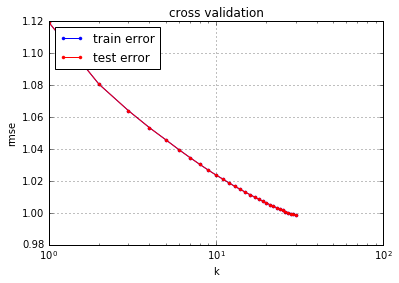

In [72]:
user_features, item_features = matrix_factorization_SGD(valid_ratings, 30, 30)

In [73]:
np.save("data/features/user_features.npy", user_features)
np.save("data/features/item_features.npy", item_features)

In [ ]:
#user_features = np.load("data/features/user_features.npy")
#item_features = np.load("data/features/item_features.npy")

In [74]:
preds_mf = predict(valid_ratings, user_features, item_features)
rmse = compute_rmse(valid_ratings, preds_mf)
rmse

0.99823073925911987

In [75]:
from helpers import load_data, preprocess_data

path_sample = "data/sampleSubmission.csv"
submission_sample = load_data(path_sample)

number of items: 1000, number of users: 10000


In [76]:
submission_preds = predict(submission_sample, user_features, item_features)

In [77]:
import csv
import sys
from helpers import write_data

path_submission = "data/submission.csv"
write_data(path_submission, submission_preds)

In [78]:
nz_row, nz_col = preds_item.nonzero()
temp = []
for i in range(0, len(nz_row)):
    temp.append([nz_row[i], nz_col[i], preds_item[nz_row[i], nz_col[i]]])
df_item = pd.DataFrame(temp)
df_item.columns = ["Item", "User", "Item mean based prediction"]
df_item.head()

,Item,User,Item mean based prediction
0,0,43,3.379412
1,0,60,3.379412
2,0,66,3.379412
3,0,71,3.379412
4,0,85,3.379412


In [79]:
nz_row, nz_col = preds_user.nonzero()
temp = []
for i in range(0, len(nz_row)):
    temp.append([nz_row[i], nz_col[i], preds_user[nz_row[i], nz_col[i]]])
df_user = pd.DataFrame(temp)
df_user.columns = ["Item", "User", "User mean based prediction"]
df_user.head()

,Item,User,User mean based prediction
0,0,43,3.893701
1,0,60,4.233696
2,0,66,3.580645
3,0,71,3.861423
4,0,85,4.103321


In [80]:
nz_row, nz_col = preds_mf.nonzero()
temp = []
for i in range(0, len(nz_row)):
    temp.append([nz_row[i], nz_col[i], preds_mf[nz_row[i], nz_col[i]]])
df_mf = pd.DataFrame(temp)
df_mf.columns = ["Item", "User", "MF prediction"]
df_mf.head()

,Item,User,MF prediction
0,0,43,3.471821
1,0,60,3.595781
2,0,66,3.246985
3,0,71,3.427019
4,0,85,3.602850


In [81]:
nz_row, nz_col = valid_ratings.nonzero()
temp = []
for i in range(0, len(nz_row)):
    temp.append([nz_row[i], nz_col[i], valid_ratings[nz_row[i], nz_col[i]]])
df_real = pd.DataFrame(temp)
df_real.columns = ["Item", "User", "Real values"]
df_real.head()

,Item,User,Real values
0,0,43,4.0
1,0,60,3.0
2,0,66,4.0
3,0,71,3.0
4,0,85,5.0


In [82]:
df_all = df_real.copy()
df_all["item diff"] = np.square(df_real["Real values"] - df_item["Item mean based prediction"])
df_all["user diff"] = np.square(df_real["Real values"] - df_user["User mean based prediction"])
df_all["mf diff"] = np.square(df_real["Real values"] - df_mf["MF prediction"])
df_all.head()

,Item,User,Real values,item diff,user diff,mf diff
0,0,43,4.0,0.385130,0.011300,0.278973
1,0,60,3.0,0.143953,1.522005,0.354955
2,0,66,4.0,0.385130,0.175858,0.567031
3,0,71,3.0,0.143953,0.742050,0.182345
4,0,85,5.0,2.626306,0.804033,1.952027


In [83]:
df_all["item nb rating"] =  df_all.groupby(["Item"])['Real values'].transform('count')
df_all["user nb rating"] =  df_all.groupby(["User"])['Real values'].transform('count')
df_all.head()

,Item,User,Real values,item diff,user diff,mf diff,item nb rating,user nb rating
0,0,43,4.0,0.385130,0.011300,0.278973,340,254
1,0,60,3.0,0.143953,1.522005,0.354955,340,184
2,0,66,4.0,0.385130,0.175858,0.567031,340,62
3,0,71,3.0,0.143953,0.742050,0.182345,340,267
4,0,85,5.0,2.626306,0.804033,1.952027,340,271


In [115]:
df_item_best = df_all[(df_all["item diff"] < df_all["user diff"]) & (df_all["item diff"] < df_all["mf diff"])]
df_item_best[["Real values", "item nb rating", "user nb rating"]].describe()

,Real values,item nb rating,user nb rating
count,360067.000000,360067.000000,360067.000000
mean,3.848806,1934.190220,157.541047
std,1.153616,1093.069454,76.654691
min,1.000000,8.000000,3.000000
25%,3.000000,1029.000000,100.000000
50%,4.000000,1782.000000,145.000000
75%,5.000000,2697.000000,203.000000
max,5.000000,4590.000000,522.000000


In [116]:
df_user_best = df_all[(df_all["user diff"] < df_all["item diff"]) & (df_all["user diff"] < df_all["mf diff"])]
df_user_best[["Real values", "item nb rating", "user nb rating"]].describe()

,Real values,item nb rating,user nb rating
count,447548.000000,447548.000000,447548.000000
mean,3.830407,1837.262097,151.094513
std,0.995290,1025.427902,77.434979
min,1.000000,8.000000,5.000000
25%,3.000000,987.000000,94.000000
50%,4.000000,1657.000000,138.000000
75%,5.000000,2568.000000,195.000000
max,5.000000,4590.000000,522.000000


In [117]:
df_mf_best = df_all[(df_all["mf diff"] < df_all["user diff"]) & (df_all["mf diff"] < df_all["item diff"])]
df_mf_best[["Real values", "item nb rating", "user nb rating"]].describe()

,Real values,item nb rating,user nb rating
count,369298.000000,369298.000000,369298.00000
mean,3.898123,2095.544249,163.20158
std,1.220779,1121.905365,79.82078
min,1.000000,8.000000,3.00000
25%,3.000000,1128.000000,104.00000
50%,4.000000,2046.000000,150.00000
75%,5.000000,3001.000000,209.00000
max,5.000000,4590.000000,522.00000


In [119]:
df_mf_best[["Real values", "item nb rating", "user nb rating"]].describe() / df_user_best[["Real values", "item nb rating", "user nb rating"]].describe()

,Real values,item nb rating,user nb rating
count,0.825158,0.825158,0.825158
mean,1.017679,1.140580,1.080129
std,1.226557,1.094085,1.030810
min,1.000000,1.000000,0.600000
25%,1.000000,1.142857,1.106383
50%,1.000000,1.234762,1.086957
75%,1.000000,1.168614,1.071795
max,1.000000,1.000000,1.000000


In [120]:
df_mf_best[["Real values", "item nb rating", "user nb rating"]].describe() / df_item_best[["Real values", "item nb rating", "user nb rating"]].describe()

,Real values,item nb rating,user nb rating
count,1.025637,1.025637,1.025637
mean,1.012814,1.083422,1.035931
std,1.058219,1.026381,1.041303
min,1.000000,1.000000,1.000000
25%,1.000000,1.096210,1.040000
50%,1.000000,1.148148,1.034483
75%,1.000000,1.112718,1.029557
max,1.000000,1.000000,1.000000


In [141]:
item_grouped = df_all.copy()
item_grouped = item_grouped.groupby("Item").agg({'item nb rating' : np.mean,'item diff' : np.mean, 'user diff' : np.mean, 'mf diff' : np.mean,})[["mf diff", "item diff", "user diff", "item nb rating"]].reset_index()
item_grouped = item_grouped.sort_values(["item nb rating"])
item_grouped.head()

,Item,mf diff,item diff,user diff,item nb rating
954,954,3.293503,0.984375,3.074152,8
927,927,3.949321,1.534626,4.042670,19
783,783,2.357672,1.673525,2.502025,27
467,467,1.402044,1.212620,1.439705,27
945,945,1.822445,1.076217,1.951145,33


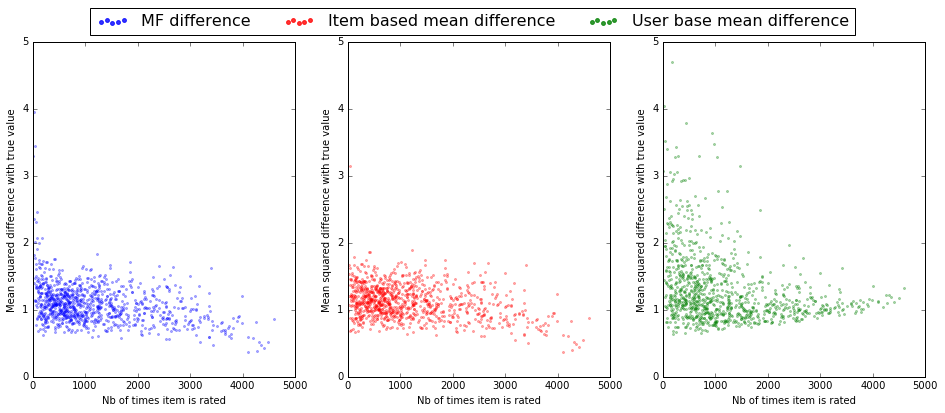

In [177]:
fig = plt.figure(figsize=(16, 6))
ax1 = fig.add_subplot(1, 3, 1)
ax2 = fig.add_subplot(1, 3, 2)
ax3 = fig.add_subplot(1, 3, 3)
mf_diff = ax1.scatter(item_grouped["item nb rating"], item_grouped["mf diff"], color='b', s=4, marker='o', alpha=.3)
item_diff = ax2.scatter(item_grouped["item nb rating"], item_grouped["item diff"], color='r', s=4, marker='o', alpha=.3)
user_diff = ax3.scatter(item_grouped["item nb rating"], item_grouped["user diff"], color='g', s=4, marker='o', alpha=.3)
ax1.set_xlabel("Nb of times item is rated")
ax1.set_ylabel("Mean squared difference with true value")
ax2.set_xlabel("Nb of times item is rated")
ax2.set_ylabel("Mean squared difference with true value")
ax3.set_xlabel("Nb of times item is rated")
ax3.set_ylabel("Mean squared difference with true value")
ax1.axis([0, 5000, 0, 5])
ax2.axis([0, 5000, 0, 5])
ax3.axis([0, 5000, 0, 5])

lgnd = fig.legend((mf_diff, item_diff, user_diff),
           ('MF difference', 'Item based mean difference', 'User base mean difference'),
           scatterpoints=5,
           loc='upper center',
           ncol=3,
           fontsize=16)

lgnd.legendHandles[0]._sizes = [15]
lgnd.legendHandles[1]._sizes = [15]
lgnd.legendHandles[2]._sizes = [15]
lgnd.legendHandles[0].set_alpha(0.8)
lgnd.legendHandles[1].set_alpha(0.8)
lgnd.legendHandles[2].set_alpha(0.8)

In [158]:
user_grouped = df_all.copy()
user_grouped = user_grouped.groupby("User").agg({'user nb rating' : np.mean,'item diff' : np.mean, 'user diff' : np.mean, 'mf diff' : np.mean,})[["mf diff", "item diff", "user diff", "user nb rating"]].reset_index()
user_grouped = user_grouped.sort_values(["user nb rating"])
user_grouped.head()

,User,mf diff,item diff,user diff,user nb rating
480,480,0.132997,0.145100,0.888889,3
5787,5787,0.529785,0.538475,0.560000,5
3677,3677,0.539269,0.574169,0.805556,6
3270,3270,0.756613,0.786954,0.571429,7
2841,2841,1.110559,1.118060,1.673469,7


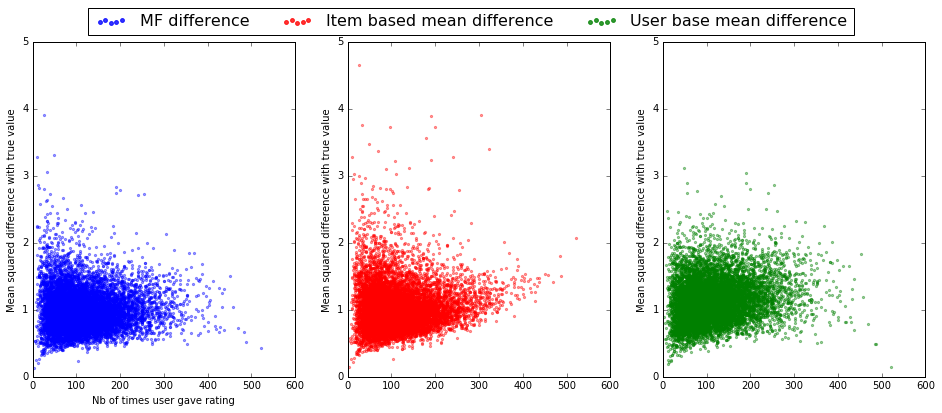

In [181]:
fig = plt.figure(figsize=(16, 6))
ax1 = fig.add_subplot(1, 3, 1)
ax2 = fig.add_subplot(1, 3, 2)
ax3 = fig.add_subplot(1, 3, 3)
mf_diff = ax1.scatter(user_grouped["user nb rating"], user_grouped["mf diff"], color='b', s=5, marker='o', alpha=.4)
item_diff = ax2.scatter(user_grouped["user nb rating"], user_grouped["item diff"], color='r', s=5, marker='o', alpha=.4)
user_diff = ax3.scatter(user_grouped["user nb rating"], user_grouped["user diff"], color='g', s=5, marker='o', alpha=.4)
ax1.set_xlabel("Nb of times user gave rating")
ax1.set_ylabel("Mean squared difference with true value")
ax1.set_xlabel("Nb of times user gave rating")
ax2.set_ylabel("Mean squared difference with true value")
ax1.set_xlabel("Nb of times user gave rating")
ax3.set_ylabel("Mean squared difference with true value")
ax1.axis([0, 600, 0, 5])
ax2.axis([0, 600, 0, 5])
ax3.axis([0, 600, 0, 5])

lgnd = fig.legend((mf_diff, item_diff, user_diff),
           ('MF difference', 'Item based mean difference', 'User base mean difference'),
           scatterpoints=5,
           loc='upper center',
           ncol=3,
           fontsize=16)

lgnd.legendHandles[0]._sizes = [15]
lgnd.legendHandles[1]._sizes = [15]
lgnd.legendHandles[2]._sizes = [15]
lgnd.legendHandles[0].set_alpha(0.8)
lgnd.legendHandles[1].set_alpha(0.8)
lgnd.legendHandles[2].set_alpha(0.8)

In [263]:
from sklearn.preprocessing import LabelEncoder  
from sklearn.ensemble import RandomForestRegressor

regressor = RandomForestRegressor(n_estimators=20, min_samples_split=0.2, max_features=3)

In [264]:
df_regression = df_real.copy()
df_regression["item preds"] = df_item["Item mean based prediction"]
df_regression["user preds"] = df_user["User mean based prediction"]
df_regression["mf preds"] = df_mf["MF prediction"]
df_regression.head()

,Item,User,Real values,item preds,user preds,mf preds
0,0,43,4.0,3.379412,3.893701,3.505570
1,0,60,3.0,3.379412,4.233696,3.625158
2,0,66,4.0,3.379412,3.580645,3.335722
3,0,71,3.0,3.379412,3.861423,3.479910
4,0,85,5.0,3.379412,4.103321,3.618830


In [187]:
regressor.fit(df_regression[["item preds","user preds","mf preds"]], df_regression["Real values"])

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features=3, max_leaf_nodes=None, min_samples_leaf=1,
           min_samples_split=0.1, min_weight_fraction_leaf=0.0,
           n_estimators=50, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False)

In [189]:
result = regressor.predict(df_regression[["item preds","user preds","mf preds"]])

In [194]:
def to_result(data, result):
    preds = data.copy()
    nz = preds.nonzero()
    preds[nz] = result
    return preds

In [195]:
preds = to_result(valid_ratings, result)

In [196]:
print(compute_rmse(valid_ratings, preds))

0.157090164084


In [265]:
train_data = df_regression[["item preds","user preds","mf preds"]][:int(len(df_regression)*0.8)]
test_data = df_regression[["item preds","user preds","mf preds"]][int(len(df_regression)*0.8):]

In [ ]:
from sklearn.svm import SVR
regr = SVR(kernel='poly', C=1e3, degree=2)

# Train the model using the training sets
regr.fit(train_data, df_regression["Real values"][:int(len(df_regression)*0.8)])

In [ ]:
test_result = regr.predict(test_data)
row, col = valid_ratings.nonzero()
test_valid = valid_ratings[row[int(len(df_regression)*0.8):], col[int(len(df_regression)*0.8):]]
test_preds = to_result(test_valid, test_result)
print(compute_rmse(test_valid, test_preds))

In [ ]:
train_result = regr.predict(train_data)
row, col = valid_ratings.nonzero()
train_valid = valid_ratings[row[:int(len(df_regression)*0.8)], col[:int(len(df_regression)*0.8)]]
train_preds = to_result(train_valid, train_result)
print(compute_rmse(train_valid, train_preds))

In [229]:
df_mean = (df_regression["item preds"] + df_regression["user preds"] + df_regression["mf preds"]*3) / 5
preds = to_result(valid_ratings, df_mean)

In [230]:
print(compute_rmse(valid_ratings, preds))

1.01346043587


# Result Generation

In [197]:
path_sample = "data/sampleSubmission.csv"
submission_sample = load_data(path_sample)

number of items: 1000, number of users: 10000


In [203]:
submission_preds_mf = predict(submission_sample, user_features, item_features)

In [204]:
submission_preds_item = predict_item(submission_sample, mean_item)

In [205]:
submission_preds_user = predict_user(submission_sample, mean_user)

In [214]:
nz_row, nz_col = submission_preds_mf.nonzero()
temp = []
for i in range(0, len(nz_row)):
    temp.append([nz_row[i], nz_col[i], submission_preds_mf[nz_row[i], nz_col[i]]])
submission_df_mf = pd.DataFrame(temp)
submission_df_mf.columns = ["Item", "User", "mf preds"]
submission_df_mf.head()

,Item,User,mf preds
0,0,36,3.399228
1,0,72,3.330368
2,0,155,3.658866
3,0,159,3.416334
4,0,247,3.450316


In [215]:
nz_row, nz_col = submission_preds_user.nonzero()
temp = []
for i in range(0, len(nz_row)):
    temp.append([nz_row[i], nz_col[i], submission_preds_user[nz_row[i], nz_col[i]]])
submission_df_user = pd.DataFrame(temp)
submission_df_user.columns = ["Item", "User", "User prediction"]
submission_df_user.head()

,Item,User,User prediction
0,0,36,3.757732
1,0,72,3.540000
2,0,155,4.230216
3,0,159,3.692308
4,0,247,3.928144


In [216]:
nz_row, nz_col = submission_preds_item.nonzero()
temp = []
for i in range(0, len(nz_row)):
    temp.append([nz_row[i], nz_col[i], submission_preds_item[nz_row[i], nz_col[i]]])
submission_df_item = pd.DataFrame(temp)
submission_df_item.columns = ["Item", "User", "Item prediction"]
submission_df_item.head()

,Item,User,Item prediction
0,0,36,3.379412
1,0,72,3.379412
2,0,155,3.379412
3,0,159,3.379412
4,0,247,3.379412


In [217]:
df_regression = submission_df_mf.copy()
df_regression["item preds"] = submission_df_item["Item prediction"]
df_regression["user preds"] = submission_df_user["User prediction"]
df_regression.head()

,Item,User,mf preds,item preds,user preds
0,0,36,3.399228,3.379412,3.757732
1,0,72,3.330368,3.379412,3.540000
2,0,155,3.658866,3.379412,4.230216
3,0,159,3.416334,3.379412,3.692308
4,0,247,3.450316,3.379412,3.928144


In [218]:
submission_result = regressor.predict(df_regression[["item preds","user preds","mf preds"]])

In [222]:
submission_preds = to_result(submission_sample, result)

In [223]:
path_submission = "data/submission.csv"
write_data(path_submission, submission_preds)